# Homework 4

## Lab Instructions
All your answers should be written in this notebook.  You shouldn't need to write or modify any other files.

**You should execute every block of code to not miss any dependency.**

*This exercise was developed by Maximilian Hüttenrauch for the KIT Cognitive Systems Lecture, June 2020.
  It is adapted from previous Robot Learning Lectures at TU Darmstadt, the Berkeley Deep RL Bootcamp
  [Lab1](https://sites.google.com/view/deep-rl-bootcamp/home)
  and Berkeley Deep RL Class
   [HW2](https://github.com/berkeleydeeprlcourse/homework/blob/c1027d83cd542e67ebed982d44666e0d22a00141/hw2/HW2.ipynb)
   [(license)](https://github.com/berkeleydeeprlcourse/homework/blob/master/LICENSE)*

## Introduction

This assignment will review the two classic methods for solving Markov Decision Processes (MDPs) with finite state and action spaces.
We will implement value iteration (VI) and policy iteration (PI) for a finite MDP, both of which find the optimal policy in a finite number of iterations.


In [1]:
from ex4.mdp import MDP
from ex4.misc import make_grader
from ex4.misc import plot_v_pi
from ex4.misc import expected_output_vi_finite, expected_output_vi_infinite, expected_output_vi_finite_stoch, expected_output_pi_infinite
import numpy as np

In [2]:
# Actions
DOWN = 0
RIGHT = 1
UP = 2
LEFT = 3
STAY = 4


class RoboMDP(MDP):
    O = -1e3  # Obstacles, walls or inaccessible places
    D = 2  # Dirt
    W = -1  # Water
    C = -30  # Cat
    T = 30  # Toy
    E = 0  # Empty

    grid_world = {
        "reward": [
            E, O, O, E, E, O, O, E, E, E,
            E, E, E, E, D, O, E, E, D, E,
            E, D, E, E, E, O, E, E, O, E,
            O, O, O, O, E, O, E, O, O, O,
            D, E, E, D, E, O, T, D, E, E,
            E, O, D, D, E, O, W, E, E, E,
            W, O, E, O, E, O, D, O, O, E,
            W, E, E, O, D, E, E, O, D, E,
            E, E, E, D, C, O, E, E, D, E
        ],
        "map": [
            " OO  OO   ",
            "    DO  D ",
            " D   O  O ",
            "OOOO O OOO",
            "D  D OTD  ",
            " ODD OW   ",
            "WO O ODOO ",
            "W  OD  OD ",
            "   DCO  D "
        ]
    }

    n_actions = 5
    world_dim = (9, 10)

    # Transition probabilities. Each row corresponds to one action, i.e. choosing action down has a 70% chance of
    # executing correctly, and 10% chance for executing right, left or stay.
    # Usage: self.tp[actual_action, noisy_executed_action]

    #             down, right, up, left, stay
    tp = np.array([[0.7, 0.1, 0.0, 0.1, 0.1],  # down
                  [0.1, 0.7, 0.1, 0.0, 0.1],  # right
                  [0.0, 0.1, 0.7, 0.1, 0.1],  # up
                  [0.1, 0.0, 0.1, 0.7, 0.1],  # left
                  [0.0, 0.0, 0.0, 0.0, 1.0]])  # stay

    def __init__(self, discount: float, stochastic: bool):
        super(RoboMDP, self).__init__(discount, self.world_dim, self.n_actions, desc=self.grid_world['map'])

        def inc(row: int, col: int, action: int):
            if action == DOWN:  # move down
                row = min(row+1, self.world_dim[0] - 1)
            elif action == RIGHT:  # move right
                col = min(col+1, self.world_dim[1] - 1)
            elif action == UP:  # move up
                row = max(row - 1, 0)
            elif action == LEFT:  # move left
                col = max(col - 1, 0)
            elif action == STAY:  # stay
                pass  # Not moving
            return row, col
        
        # We need to set the next state with its corresponding transition probability based on the current state and 
        # action. Have a look at mdp.py for the implementation of self.stp
        for r in range(self.world_dim[0]):
            for c in range(self.world_dim[1]):
                s = self.to_s(r, c)
                self.rewards[s] = self.grid_world["reward"][s]
                for a in range(self.n_actions):
                    stp_list = self.stp[s, a]
                    if stochastic:
                        for noisy_a in range(self.n_actions):
                            if self.tp[a, noisy_a] > 0:
                                next_r, next_c = inc(r, c, noisy_a)
                                next_state = self.to_s(next_r, next_c)
                                stp_list.append((next_state, self.tp[a, noisy_a]))
                    else:
                        next_r, next_c = inc(r, c, a)
                        next_state = self.to_s(next_r, next_c)
                        stp_list.append((next_state, 1.))

    # helper functions

    def to_s(self, row, col):
        """given a row and column, returns a linear index corresponding to the world dimension"""
        return row * self.world_dim[1] + col

    def to_rc(self, s):
        """given a linear state, returns a row and column corresponding to the world dimension"""
        return np.unravel_index(s, self.world_dim)

## Part 1: Value Iteration

### Implementing value iteration
For exercise 3, you'll implement value iteration, which has the following pseudocode:

---
Initialize $V_{(0)}^\ast(s)=0$, for all $s$

For $i=0, 1, 2, \dots$
- $V^\ast_{(i+1)}(s) = \max_a  \Big( r(s,a) + \gamma \sum_{s'} P(s' \mid s,a) \, V^\ast_{(i)}(s') \Big)$, for all $s$
- Until convergence or horizon $H$

---

We additionally define the sequence of greedy policies $\pi_{(0)}, \pi_{(1)}, \dots, \pi_{(n-1)}$, where
$$\pi^\ast_{(i)}(s) = \underset{a}{\arg \max} \Big( r(s,a) + \gamma \sum_{s'} P(s' \mid s,a) V^\ast_{(i)}(s')\Big)$$

Your code will return two lists: $[V_{(0)}, V_{(1)}, \dots, V_{(n)}]$ and $[\pi_{(0)}, \pi_{(1)}, \dots, \pi_{(n-1)}]$

To ensure that you get the same policies as the reference solution, choose the lower-index action to break ties in $\arg \max_a$. This is done automatically by np.argmax. This will only affect the "# chg actions" printout below--it won't affect the values computed.

<div class="alert alert-warning">
Warning: make a copy of your value function each iteration and use that copy for the update--don't update your value function in place.
Updating in-place is also a valid algorithm, sometimes called Gauss-Seidel value iteration or asynchronous value iteration, but it will cause you to get different results than our reference solution (which in turn will mean that our testing code won’t be able to help in verifying your code).
</div>

#### Hints
- The reward function can be accessed by $\texttt{mdp.rewards[s]}$, the next states and their probability of reaching
 them (given a state $s$ and and action $a$) by $\texttt{mdp.stp[s, a]}$
- Use the functions $\texttt{to_s}$ and $\texttt{to_rc}$ provided by the MDP class to convert between linear states
 $s \in [0, |\mathcal{S}|]$ and row/column format, i.e. $\texttt{mdp.to_rc(0)}$ returns $(0, 0)$, while
 $\texttt{mdp.to_s(0, 0)}$ returns $0$
- For your implementation, the identities $V^\ast(s) = \max_a Q^\ast(s, a)$ and
 $\pi^\ast(s) = \underset{a}{\arg \max} \, Q^\ast(s, a)$ may be helpful
- Following numpy functions may be useful: $\texttt{np.sum}$, $\texttt{np.max}$, $\texttt{np.argmax}$
- Try using list comprehensions as this will shorten your code
- For the infinite horizon case, we request 100 iterations of value iteration. However, the algorithm should converge
earlier.


In [3]:
def value_iteration(mdp: MDP, n_iter: int, grade_print=print) -> (list, list):
    """
    Inputs:
    @param mdp: an MDP object
    @param n_iter: number of VI iterations
    @param grade_print:
    Outputs:
    @return: (value_functions, policies)

    len(value_functions) == n_iter+1 and len(policies) == n_iter
    """
    vs = [np.zeros(shape=mdp.world_dim)]  # list of value functions contains the initial value function V_{(0)}, which is zero
    pis = []  # list containing sequence of previous greedy policies

    grade_print("Iteration |  max|V-Vprev|  | # chg actions | V[0]    ")
    grade_print("----------+----------------+---------------+---------")
    for it in range(0, n_iter):
        pi_old = pis[-1] if len(pis) > 0 else None  # \pi^{(it)} = Greedy[V^{(it-1)}]. Just used for printout
        v_old = vs[-1]

        pi = np.zeros(shape=mdp.world_dim)  # contains the actual actions
        v = np.zeros(shape=mdp.world_dim)  # new value function
        for s in range(mdp.n_states):  # loop over all states
            r, c = mdp.to_rc(s)  # convert to row, column format
            q = []  # list for q values in current state
            for a in range(mdp.n_actions):
                """
                # longer, explicit version
                pv_sum = 0
                for s_dash, tp in mdp.stp[s, a]:
                    r_dash, c_dash = mdp.to_rc(s_dash)
                    pv_sum += tp * v_old[r_dash, c_dash]

                q_s_a = mdp.rewards[s] + mdp.gamma * pvsum
                """

                # one-liner implementing above for-loop over state transitions
                q_s_a = mdp.rewards[s] + mdp.gamma * np.sum([tp * v_old[mdp.to_rc(s_dash)] for s_dash, tp in mdp.stp[s, a]])
                q.append(q_s_a)

            v_star = np.max(q)  # optimal value
            a_star = np.argmax(q)  # optimal action
            v[r, c] = v_star
            pi[r, c] = a_star

        max_diff = np.abs(v - v_old).max()
        n_chg_actions = 0 if pi_old is None else (pi != pi_old).sum()
        grade_print("{:4d}      | {:12.5f}   |   {:4d}        | {:8.3f}".format(it, max_diff, n_chg_actions, v[0, 0]))

        vs.append(v)
        pis.append(pi)

        if max_diff < 1e-5:
            break

    return vs, pis

## 4 b) Finite Horizon Problem

Iteration |  max|V-Vprev|  | # chg actions | V[0]    
----------+----------------+---------------+---------
   0      |   1000.00000   |      0        |    0.000
   1      |     30.00000   |     50        |    0.000
   2      |     30.00000   |     11        |    0.000
   3      |     30.00000   |      6        |    2.000
   4      |     30.00000   |      8        |    4.000
   5      |     30.00000   |      5        |    6.000
   6      |     30.00000   |      3        |    8.000
   7      |     30.00000   |      2        |   10.000
   8      |     30.00000   |      3        |   12.000
   9      |     30.00000   |      0        |   14.000
  10      |     30.00000   |      1        |   16.000
  11      |     30.00000   |      2        |   18.000
  12      |     30.00000   |      4        |   20.000
  13      |     30.00000   |      3        |   22.000
  14      |     30.00000   |      0        |   24.000
Test succeeded


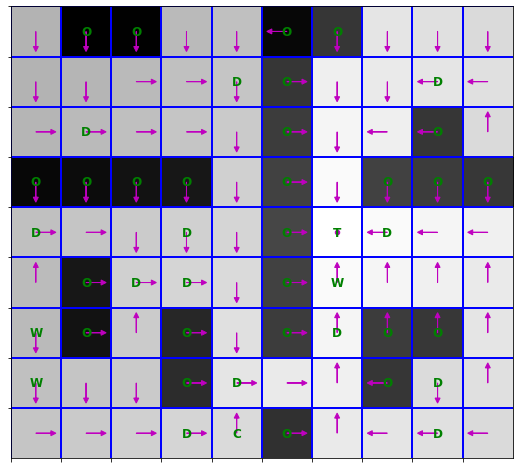

In [4]:
robo_mdp_finite = RoboMDP(discount=1, stochastic=False)
v_finite, pi_finite = value_iteration(robo_mdp_finite, 15, make_grader(expected_output_vi_finite))

plot_v_pi(v_finite[-1], pi_finite[-1], robo_mdp_finite)

In [ ]:
# Put your text answers here

"""
The robot does not avoid the cat. Due to the finite horizon, the loss in reward of moving around the
obstacles in states (7, 4) and (8, 4) outweighs the negative reward of the encounter with the cat.
"""

## 4 c) Infinite Horizon Formulation

Change this equation to the infinite horizon formulation:

$$J_\pi = \sum_{t=1}^{T} r_t(s_t)$$

In [ ]:
# Put your text answers here

"""
A discount factor 0 < γ < 1 puts more emphasis on sooner rewards and is necessary for the infinite
sum to converge since 􏰀sum_{t=1}^T γ^{t−1}r_t(s_t) < ∞ only if max(|r|) < ∞ and γ < 1.
"""


## 4 d) Infinite Horizon Problem

Iteration |  max|V-Vprev|  | # chg actions | V[0]    
----------+----------------+---------------+---------
   0      |   1000.00000   |      0        |    0.000
   1      |     24.00000   |     50        |    0.000
   2      |     19.20000   |     11        |    0.000
   3      |     15.36000   |      6        |    1.024
   4      |     12.28800   |      8        |    1.843
   5      |      9.83040   |      5        |    2.499
   6      |      7.86432   |      3        |    3.023
   7      |      6.29146   |      2        |    3.442
   8      |      5.03316   |      0        |    3.778
   9      |      4.02653   |      2        |    4.046
  10      |      3.22123   |      0        |    4.261
  11      |      2.57698   |      0        |    4.433
  12      |      2.06158   |      3        |    4.570
  13      |      1.64927   |      1        |    4.680
  14      |      1.31941   |      2        |    4.768
  15      |      1.05553   |      3        |    4.839
  16      |      0.84442   |

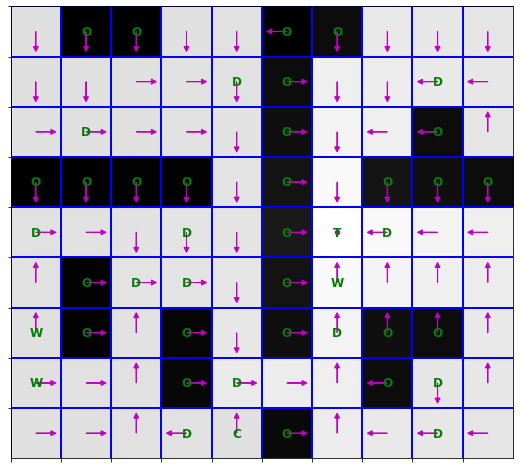

In [5]:
robo_mdp_infinite = RoboMDP(discount=0.8, stochastic=False)
v_infinite, pi_infinite = value_iteration(robo_mdp_infinite, 100, make_grader(expected_output_vi_infinite))

plot_v_pi(v_infinite[-1], pi_infinite[-1], robo_mdp_infinite)

In [ ]:
# Put your text answers here

"""
The robot is now avoiding the cat. Due to the infinite horizon, the loss in reward of moving around the obstacles in
states (7, 4) and (8, 4) does not outweigh the negative reward of the encounter with the cat anymore.
"""

## 4 e) Finite Horizon Problem with Stochastic Transitions

Iteration |  max|V-Vprev|  | # chg actions | V[0]    
----------+----------------+---------------+---------
   0      |   1000.00000   |      0        |    0.000
   1      |    300.00000   |     65        |    0.000
   2      |     90.00000   |      5        |    0.000
   3      |     30.00000   |      3        |    0.100
   4      |     30.00000   |      1        |    0.310
   5      |     30.00000   |      1        |    0.641
   6      |     30.00000   |      0        |    1.088
   7      |     30.00000   |      1        |    1.650
   8      |     30.00000   |      0        |    2.318
   9      |     30.00000   |      1        |    3.088
  10      |     30.00000   |      0        |    3.953
  11      |     30.00000   |      0        |    4.905
  12      |     30.00000   |      1        |    5.939
  13      |     30.00000   |      0        |    7.050
  14      |     30.00000   |      0        |    8.230
Test succeeded


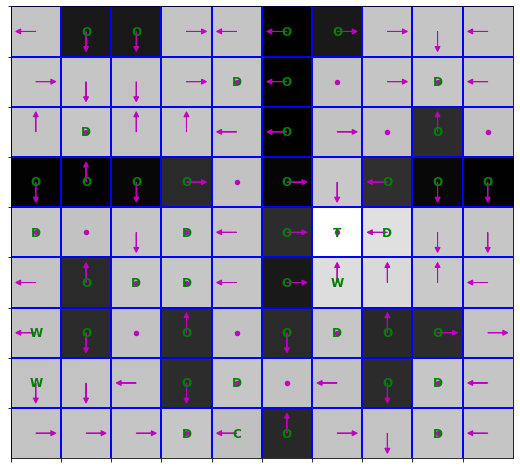

In [6]:
robo_mdp_finite_stoch = RoboMDP(discount=1, stochastic=True)
v_finite_stoch, pi_finite_stoch = value_iteration(robo_mdp_finite_stoch, 15, make_grader(expected_output_vi_finite_stoch))

plot_v_pi(v_finite_stoch[-1], pi_finite_stoch[-1], robo_mdp_finite_stoch)

In [ ]:
# Put your text answers here

"""
Due to the stochasticity of transitions, the robot avoids almost all actions that could result running into an obstacle,
except when directly near the toy. Therefore, it pursues smaller rewards obtained by cleaning dirt.
The transition between states (2, 3) and (3, 3) looks like an infinite loop but it is broken by accidentally going left
or right due to the stochasticity.
"""